In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import pysynphot as S
import scipy
import os

os.chdir("/Users/keith/astr/research_astr/summer-roman-project/4) FOV0_sims/fits")

/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/refs.py:117: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/keith/PYSYN_CDBS/mtab/*_tmg.fits
  warnings.warn('No graph or component tables found; '
/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/refs.py:124: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/keith/PYSYN_CDBS/mtab/*_tmt.fits
  warnings.warn('No thermal tables found, '


In [2]:
file = fits.open("GRS_FOV0_roll0_dx0_dy0_SCA1_slitless_final.fits")
hlss_data = file[1].data
file.close()

file = fits.open("integrated_sim.fits")
grizli_data = file[1].data
file.close

df = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/wfirst_wfi_f158_001_syn.fits", format='fits')
bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])

spec_temp = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/SED:rest:gal.2678.fits", format="fits")
spec = S.ArraySpectrum(wave=spec_temp["wavelength"], flux=spec_temp["flux"], waveunits="angstroms", fluxunits="flam").redshift(1.464803)
spec = spec.renorm(20.41, "abmag", bp)
spec.convert("flam")

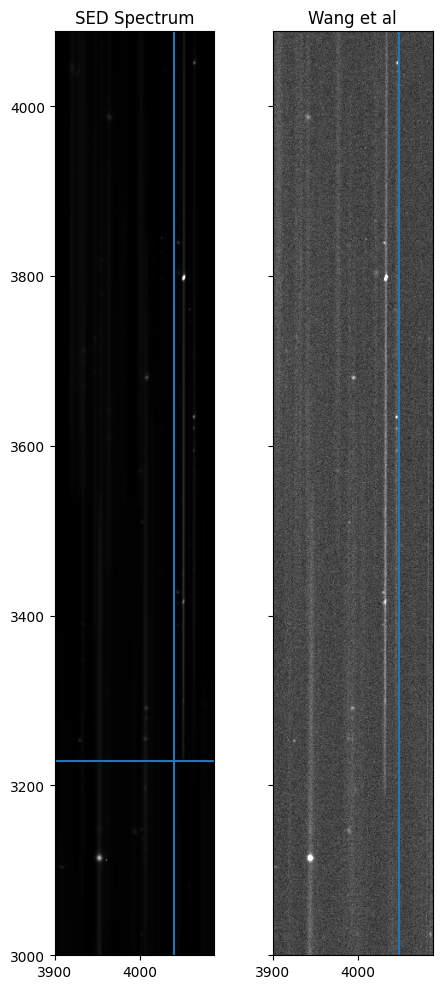

In [3]:
# Display comparison image
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(5,10))

ax2.imshow(grizli_data, origin="lower", cmap='grey', vmax=hlss_data.max()/100)
ax2.set_xlim(3900,4088)
ax2.set_ylim(3000,4088)
ax2.set_title("SED Spectrum")

ax3.imshow(hlss_data, origin="lower", cmap='grey', vmax=hlss_data.max()/100)
ax3.set_xlim(3900,4088)
ax3.set_ylim(3000,4088)
ax3.set_title("Wang et al")
ax3.set_yticklabels([])

ax2.axvline(4040)
ax3.axvline(4048)

ax2.axhline(3229)

fig.tight_layout()

Text(0.5, 1.0, 'Spetrum Template')

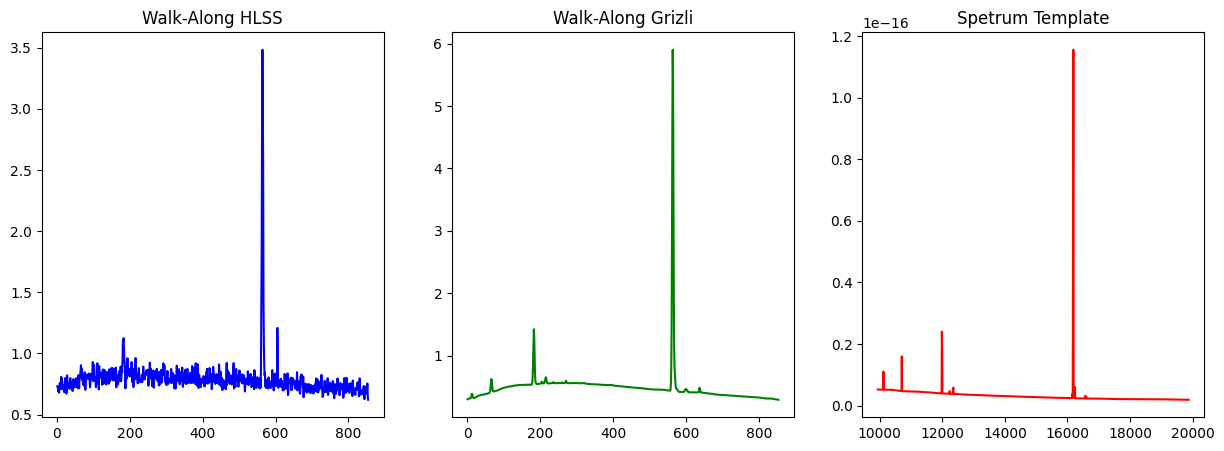

In [4]:
# Walk along HLSS
hlss_cutout = hlss_data[3234:, 4030:4036]
steps = hlss_cutout.shape[0]
hlss_flux = np.asarray([np.max(hlss_cutout[ii, :])for ii in range(steps)])
x = np.linspace(1, steps, steps)

# Walk along Grizli
grizli_cutout = grizli_data[3234:, 4049:4055]
steps = grizli_cutout.shape[0]
grizli_flux = np.asarray([np.sum(grizli_cutout[ii, :])for ii in range(steps)])

# Plot walk along against template
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

ax1.plot(x, hlss_flux, c='b')
ax1.set_title("Walk-Along HLSS")

ax2.plot(x, grizli_flux, c='g')
ax2.set_title("Walk-Along Grizli")

ax3.plot(spec.wave, spec.flux, c='r')
ax3.set_title("Spetrum Template")

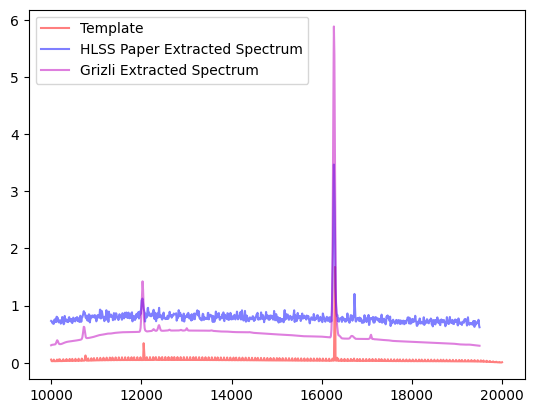

In [5]:
hlss_max_wave = 19500
hlss_wave = np.linspace(10000, hlss_max_wave, len(hlss_flux))
hlss_interp_wave = np.linspace(10000, hlss_max_wave, hlss_max_wave-10000)

wave = np.linspace(10000,20000,1001)
sens = Table.read("/Users/keith/astr/research_astr/summer-roman-project/toy_configs/sens_0720_2020.fits", format="fits")
interpolated_sens = np.interp(wave, sens["WAVELENGTH"], sens["SENSITIVITY"])

hlss_extract = np.interp(hlss_interp_wave, hlss_wave, hlss_flux)
grizli_extract = np.interp(hlss_interp_wave, hlss_wave, grizli_flux)

spec_flux = (spec.flux * interpolated_sens)
spec_flux = scipy.stats.binned_statistic(spec.wave, spec_flux, statistic="sum", bins=steps)[0]
wave = np.linspace(10000, 20000, steps)

plt.plot(wave, spec_flux, c='r', alpha=0.5, label="Template")
plt.plot(hlss_interp_wave, hlss_extract, c='b', alpha=0.5, label="HLSS Paper Extracted Spectrum")
plt.plot(hlss_interp_wave, grizli_extract, c='m', alpha=0.5, label="Grizli Extracted Spectrum")

plt.legend()